<a href="https://colab.research.google.com/github/danglive/Segmentation-using-Unet/blob/master/SegFingerNails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Build Unet Model 

In [0]:
import numpy as np
import tarfile
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
from IPython.display import clear_output


def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou


class fingernailseg:
    
    epochs = 50
    batch_size = 4
    val_split = .1
    sz = (192, 160)
    
    def __init__(self, dataset):
        if len(dataset):
            tar = tarfile.open(dataset)
            tar.extractall()
            tar.close()
        mask_files = os.listdir('nails/mask')
        raw_files = os.listdir('nails/raw')
        # find intersection of two lists
        files = list(set(raw_files).intersection(mask_files))
        test_files = list(set(mask_files).symmetric_difference(raw_files))
        X_train = []
        X_test = []
        y = []
        for f in files:
            mask = Image.open('nails/mask/'+f)
            mask = np.array(mask.resize(self.sz))
            mask = mask.mean(axis=2)
            mask[mask<250]=0
            mask[mask>0]=1
            if not mask.sum():
                continue
            y.append(mask)
            raw = Image.open('nails/raw/'+f)
            raw = np.array(raw.resize(self.sz))
            X_train.append(raw)
        for f in test_files:
            try:
                raw = Image.open('nails/raw/'+f)
            except:
                continue
            raw = np.array(raw.resize(self.sz))
            X_test.append(raw)
        X_train = np.array(X_train).astype('float32')
        X_train /= 255
        X_test = np.array(X_test).astype('float32')
        X_test /= 255
        self.X_test = X_test
        self.X_train = X_train
        y = np.array(y)
        self.y = np.expand_dims(y,3)
        self.sz = self.sz[::-1] + (3,)
        
    def plot_example(self, im_num = 13):
        plt.figure(figsize=(5,5))
        plt.imshow(self.X_train[im_num,:,:,:])
        plt.imshow(self.y[im_num,:,:,0], alpha=0.3)
        
    def create_unet(self):
        s = Input(self.sz)
        c1 = Conv2D(8, 3, activation='relu', padding='same') (s)
        c1 = Conv2D(8, 3, activation='relu', padding='same') (c1)
        p1 = MaxPooling2D() (c1)
        c2 = Conv2D(16, 3, activation='relu', padding='same') (p1)
        c2 = Conv2D(16, 3, activation='relu', padding='same') (c2)
        p2 = MaxPooling2D() (c2)
        c3 = Conv2D(32, 3, activation='relu', padding='same') (p2)
        c3 = Conv2D(32, 3, activation='relu', padding='same') (c3)
        p3 = MaxPooling2D() (c3)
        c4 = Conv2D(64, 3, activation='relu', padding='same') (p3)
        c4 = Conv2D(64, 3, activation='relu', padding='same') (c4)
        p4 = MaxPooling2D() (c4)
        c5 = Conv2D(128, 3, activation='relu', padding='same') (p4)
        c5 = Conv2D(128, 3, activation='relu', padding='same') (c5)
        u6 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (c5)
        u6 = Concatenate(axis=3)([u6, c4])
        c6 = Conv2D(64, 3, activation='relu', padding='same') (u6)
        c6 = Conv2D(64, 3, activation='relu', padding='same') (c6)
        u7 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (c6)
        u7 = Concatenate(axis=3)([u7, c3])
        c7 = Conv2D(32, 3, activation='relu', padding='same') (u7)
        c7 = Conv2D(32, 3, activation='relu', padding='same') (c7)
        u8 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same') (c7)
        u8 = Concatenate(axis=3)([u8, c2])
        c8 = Conv2D(16, 3, activation='relu', padding='same') (u8)
        c8 = Conv2D(16, 3, activation='relu', padding='same') (c8)
        u9 = Conv2DTranspose(8, 2, strides=(2, 2), padding='same') (c8)
        u9 = Concatenate(axis=3)([u9, c1])
        c9 = Conv2D(8, 3, activation='relu', padding='same') (u9)
        c9 = Conv2D(8, 3, activation='relu', padding='same') (c9)
        outputs = Conv2D(1, 1, activation='sigmoid') (c9)
        self.model = Model(inputs=[s], outputs=[outputs])

        self.model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = [mean_iou])
        
    def build_callbacks(self):
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        stop_train = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                    patience=3, min_lr=0.00001)
        callbacks = [checkpointer, reduce_lr, stop_train, PlotLearning()]
        return callbacks
    
    def fit(self):
        self.model.fit(self.X_train, self.y, validation_split=self.val_split, verbose=0, 
                       batch_size=self.batch_size, epochs=self.epochs, callbacks=self.build_callbacks())
            
    def load_model(self):
        self.model.load_weights('unet.h5')

    def predict(self):
        return self.model.predict(self.X_test, batch_size=self.batch_size, verbose=0)
    
    @classmethod # change NN model
    def change_model(cls, net):
        cls.net = net
    @classmethod
    def set_num_epochs(cls, new_epochs):
        cls.epochs = new_epochs
    @classmethod
    def set_batch_size(cls, new_batch_size):
        cls.batch_size = new_batch_size
    @classmethod
    def set_val_split(cls, new_split):
        cls.val_split = new_split
    @classmethod
    def set_sz(cls, new_sz):
        cls.sz = new_sz

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback, fingernailseg):
    def __init__(self):
        fingernailseg.__init__(self, '')
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        fig, ax1 = plt.subplots(figsize=(10,5));
        clear_output(wait=True)
        lns1 = ax1.plot(self.x, self.acc, label="Mean IoU", color='blue', linewidth = 3.);
        lns2 = ax1.plot(self.x, self.val_acc, label="Mean validation IoU", color='green', linewidth = 3.);
        ax1.set_ylabel('IoU',fontsize=15);
        ax1.set_xlabel('Epoch',fontsize=15);
        ax1.set_title('Fingernails U-Net Segmentation Model');
        ax2 = ax1.twinx()
        lns3 = ax2.plot(self.x, self.losses, '--', label="loss", color='orange');
        lns4 = ax2.plot(self.x, self.val_losses, '--', label="validation loss", color='red');
        ax2.set_ylabel('Loss',fontsize=15)
        lns = lns1+lns2+lns3+lns4
        ax1.legend(lns, [l.get_label() for l in lns])
        ax1.grid(True)
        plt.xlim([-0.05, self.epochs+.05])
        plt.show();

#Fingernails Segmentation

Load dataset

In [9]:
!wget "https://github.com/danglive/Segmentation-using-Unet/raw/master/nails.tar.gz"

--2019-11-16 16:05:35--  https://github.com/danglive/Segmentation-using-Unet/raw/master/nails.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/danglive/Segmentation-using-Unet/master/nails.tar.gz [following]
--2019-11-16 16:05:35--  https://raw.githubusercontent.com/danglive/Segmentation-using-Unet/master/nails.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19094516 (18M) [application/octet-stream]
Saving to: ‘nails.tar.gz.1’

nails.tar.gz.1      100%[===================>]  18.21M  --.-KB/s    in 0.1s    

2019-11-16 16:05:35 (161 MB/s) - ‘nails.tar.gz.1’ saved [19094516/19094516]



**Initialization**

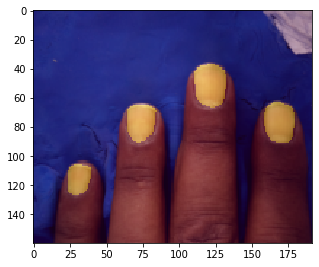

In [10]:
# initialize instance
dataset = 'nails.tar.gz'
seg = fingernailseg(dataset)
# show random example from training set
seg.plot_example(np.random.randint(seg.X_train.__len__()))
# create U-Net model
seg.create_unet()

**Trainning**

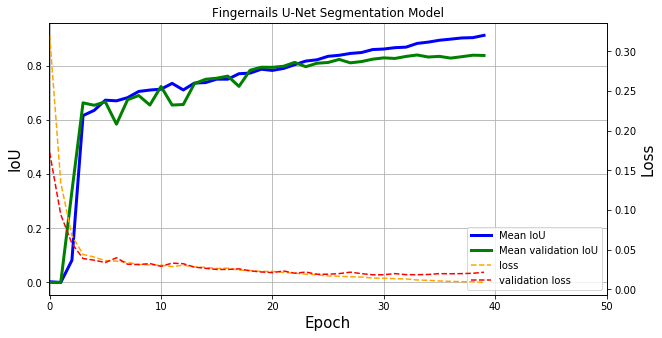

Epoch 00040: early stopping


In [11]:
seg.fit()
seg.load_model()

**Test**

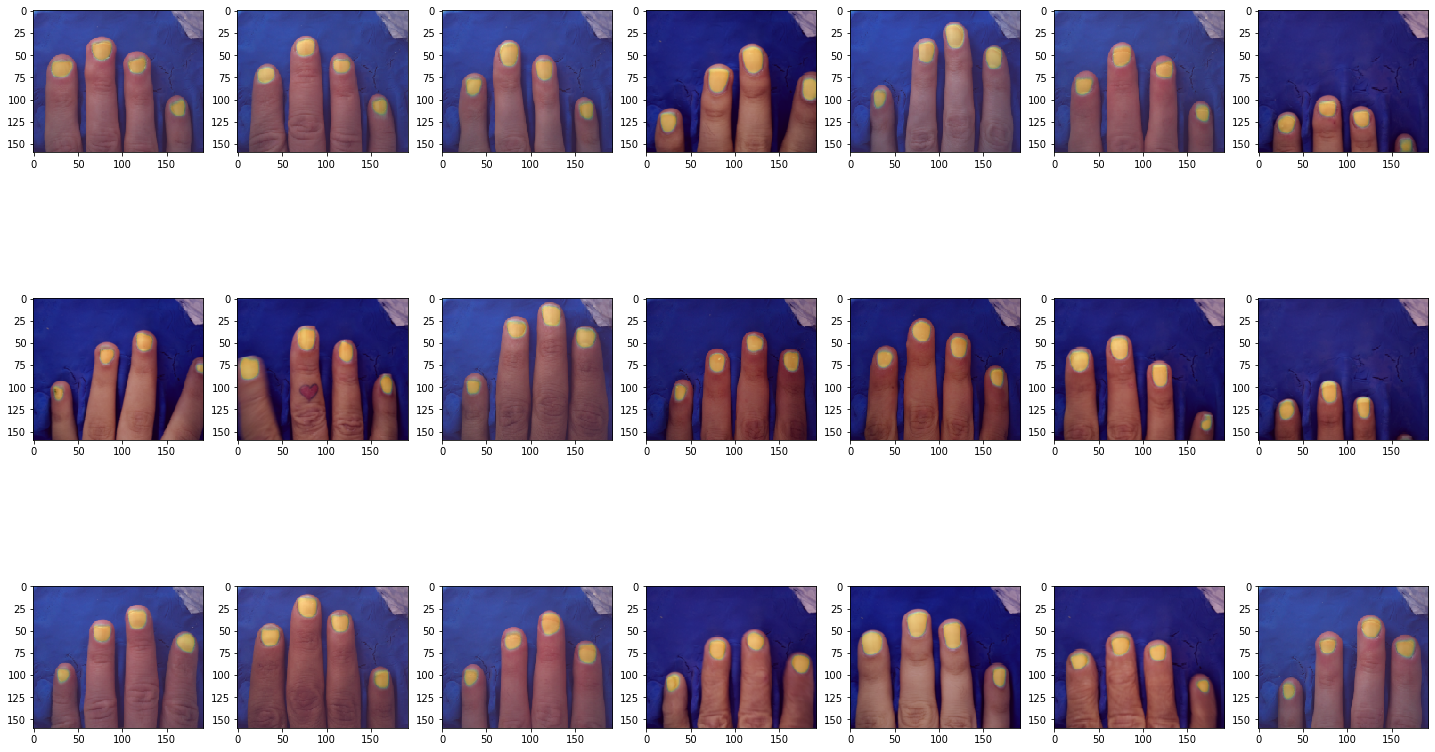

In [12]:
mask = seg.predict()
raw = seg.X_test
plt.figure(figsize=(25,15))
for i in range(len(mask)):
    plt.subplot(3, 7, i+1)
    plt.imshow(raw[i])
    plt.imshow(mask[i,:,:,0], alpha=0.3)

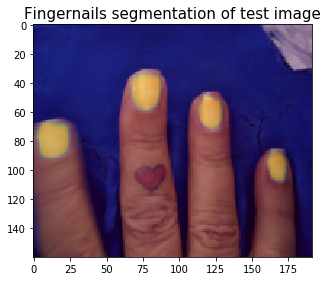

In [14]:
mask = seg.predict()
plt.figure(figsize=(5,5))

rand_image = np.random.randint(seg.X_test.__len__())
plt.imshow(raw[rand_image,:,:,:])
plt.imshow(mask[rand_image,:,:,0], alpha=0.3)
plt.title('Fingernails segmentation of test image', fontsize=15)
plt.show()